In [4]:
BASE_DIR = "/home/kyudan/AnomLLM"

In [5]:
import numpy as np
import pandas as pd
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score

def evaluate_multi_label(y_true, y_pred):

    # Set label names
    label_names = ["Trend", "Seasonality", "Noise", "Anomalies"]
    
    # Calculate individual evaluation metrics
    metrics = {
        # Exact match ratio (proportion of samples where all labels exactly match)
        'exact_match_ratio': accuracy_score(y_true, y_pred),
        
        # Hamming loss (proportion of incorrectly predicted labels)
        'hamming_loss': hamming_loss(y_true, y_pred),
        
        # Jaccard similarity (intersection/union)
        'jaccard_score': jaccard_score(y_true, y_pred, average='samples'),
        
        # Per-label accuracy
        'label_accuracy': {},
        
        # Detailed metrics (micro average: metrics calculated on the entire dataset)
        'micro_precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'micro_recall': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        
        # Detailed metrics (macro average: average of metrics calculated for each label)
        'macro_precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'macro_recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }
    
    # Calculate accuracy for each label
    for i, label in enumerate(label_names):
        label_true = y_true[:, i]
        label_pred = y_pred[:, i]
        metrics['label_accuracy'][label] = accuracy_score(label_true, label_pred)
    
    return metrics

def process_data(ground_truth_df, predictions_list):

    # Extract values from prediction results
    y_pred = []
    
    for pred_item in predictions_list:
        # Extract prediction results from JSON response
        response = pred_item["response"]
        # Extract JSON string (remove ```json and ``` and parse)
        json_str = response.strip().replace("```json", "").replace("```", "").strip()
        last_brace = json_str.rfind('}')
        if last_brace != -1:
            json_str = json_str[:last_brace+1]
        pred_dict = json.loads(json_str)
        
        # Convert to ordered list [Trend, Seasonality, Noise, Anomalies]
        pred_values = [
            pred_dict["Trend"], 
            pred_dict["Seasonality"], 
            pred_dict["Noise"], 
            pred_dict["Anomalies"]
        ]
        y_pred.append(pred_values)
    
    # Extract ground truth data
    y_true = []
    
    # Get ground truth data for the number of prediction results
    # Note: This assumes that ground truth and predictions are in the same order
    for i in range(len(y_pred)):
        if i < len(ground_truth_df):
            row = ground_truth_df.iloc[i]
            # [trend, seasonal, noise, has_anomaly]
            true_values = [
                row["trend"], 
                row["seasonal"], 
                row["noise"], 
                row["has_anomaly"]
            ]
            y_true.append(true_values)
    
    return np.array(y_true), np.array(y_pred)

def create_metrics_dataframe(metrics):

    # 1. Convert overall metrics to DataFrame
    overall_metrics = {
        'Metric': [
            'Exact Match Ratio',
            'Hamming Loss',
            'Jaccard Score',
            'Micro-Precision',
            'Micro-Recall',
            'Micro-F1',
            'Macro-Precision',
            'Macro-Recall',
            'Macro-F1'
        ],
        'Value': [
            metrics['exact_match_ratio'],
            metrics['hamming_loss'],
            metrics['jaccard_score'],
            metrics['micro_precision'],
            metrics['micro_recall'],
            metrics['micro_f1'],
            metrics['macro_precision'],
            metrics['macro_recall'],
            metrics['macro_f1']
        ]
    }
    
    overall_df = pd.DataFrame(overall_metrics)
    
    # 2. Convert label-specific accuracy to DataFrame
    label_accuracy = {
        'Label': list(metrics['label_accuracy'].keys()),
        'Accuracy': list(metrics['label_accuracy'].values())
    }
    
    label_df = pd.DataFrame(label_accuracy)
    
    return overall_df, label_df

def main(data_path = "/component_series_400.pkl/gemini-1.5-flash/component.jsonl"):

    # Load ground truth data
    gt_df = pd.read_pickle("../data/synthetic/component_series_400.pkl")
    
    # Load prediction results
    predictions = []
    with open(f"{BASE_DIR}/results/data/synthetic{data_path}", "r") as f:
        for line in f:
            predictions.append(json.loads(line.strip()))
    
    # Process data
    y_true, y_pred = process_data(gt_df, predictions)
    
    # Debug output
    print("len(y_true), len(y_pred)", len(y_true), len(y_pred))
    
    # Calculate evaluation metrics
    metrics = evaluate_multi_label(y_true, y_pred)
    
    # Convert results to DataFrames
    overall_metrics_df, label_accuracy_df = create_metrics_dataframe(metrics)
    
    # Output results
    print(f"Number of data samples: {len(y_true)}")
    
    print("\n===== Overall Evaluation Metrics =====")
    print(overall_metrics_df.to_string(index=False, float_format=lambda x: f"{x*100:.2f}"))
    
    print("\n===== Label-specific Accuracy =====")
    print(label_accuracy_df.to_string(index=False, float_format=lambda x: f"{x*100:.2f}"))
    
    # Save DataFrames to CSV (optional)
    overall_metrics_df.to_csv(f"{data_path.split('/')[-2]}_overall_metrics.csv", index=False)
    label_accuracy_df.to_csv(f"{data_path.split('/')[-2]}_label_accuracy.csv", index=False)
    
    # Return combined results (for use if needed)
    combined_results = {
        'sample_count': len(y_true),
        'overall_metrics': overall_metrics_df,
        'label_accuracy': label_accuracy_df
    }
    
    return combined_results

In [6]:
results = main("/component_series_400.pkl/gpt-4o/component.jsonl")
overall_df = results['overall_metrics']
label_df = results['label_accuracy']

len(y_true), len(y_pred) 400 400
Number of data samples: 400

===== Overall Evaluation Metrics =====
           Metric  Value
Exact Match Ratio  41.50
     Hamming Loss  19.38
    Jaccard Score  73.90
  Micro-Precision  79.41
     Micro-Recall  85.60
         Micro-F1  82.39
  Macro-Precision  75.18
     Macro-Recall  82.31
         Macro-F1  77.82

===== Label-specific Accuracy =====
      Label  Accuracy
      Trend     77.00
Seasonality    100.00
      Noise     70.25
  Anomalies     75.25


(0.0, 1.0)

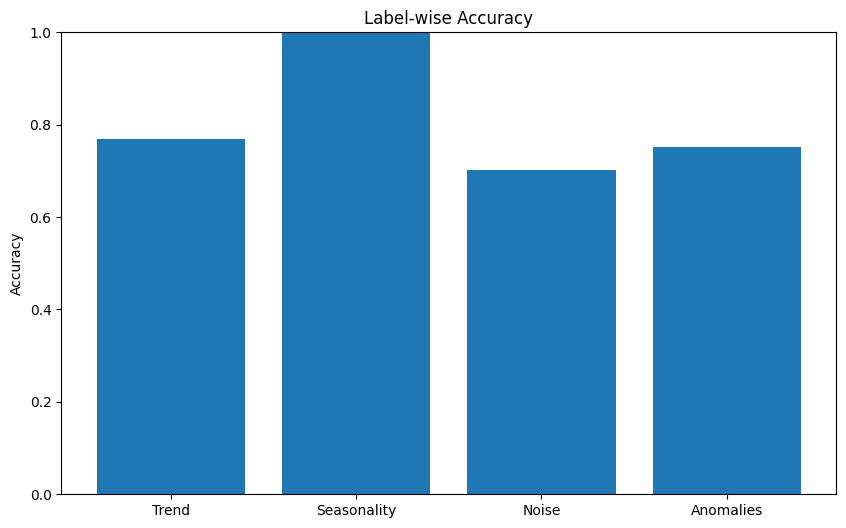

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(label_df['Label'], label_df['Accuracy'])
plt.title('Label-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('label_accuracy.png')